# Step 2 - Setting up your filter curves

The next step is to obtain the filter curves that the data you're interested in fitting was observed through. If you don't have these already I recommend the [SVO filter profie service](http://svo2.cab.inta-csic.es/svo/theory/fps/), just make sure what you're downloading definitely matches your data.

For this example we'll use a set of twelve filter curves corresponding to observations which have been made of the UltraVISTA survey field. These filter curves are in the "data/filters" directory. To start with let's load the filter curves.

In [9]:
import numpy as np

filter_names = ["data/filters/CFHT_u.txt",
                "data/filters/CFHT_g.txt",
                "data/filters/CFHT_r.txt",
                "data/filters/CFHT_i+i2.txt",
                "data/filters/CFHT_z.txt",
                "data/filters/subaru_z",
                "data/filters/VISTA_Y.txt",
                "data/filters/VISTA_J.txt",
                "data/filters/VISTA_H.txt",
                "data/filters/VISTA_Ks.txt",
                "data/filters/IRAC1",
                "data/filters/IRAC2"]

filter_curves = []

for name in filter_names:
    filter_curves.append(np.loadtxt(name))

All of these filter curves currently have transmission values at different sets of wavelength values. This is going to make it challenging to integrate our models over them. The best way of dealing with this is to resample your models and filters to the same wavelength values so you can just multiply them together and integrate. We've already resampled the models, so let's resample the filter curves to the same wavelengths.

In [10]:
wavelengths = np.arange(1000., 60000., 10.)

resampled_filter_curves = []

for filt in filter_curves:
    resampled_filt = np.interp(wavelengths, filt[:,0], filt[:,1], left=0, right=0)
    resampled_filter_curves.append(resampled_filt)

Let's take a look at the filter curves. I've bundled up the first step into a quick function so we can see what the models look like on the same axes as the filters.

In [11]:
def get_model_grid():
    """ Loads up the BPASS grid of stellar models and 
    resamples it onto a coarser wavelength grid. See Step 1. """
    
    model_path = "data/spectra-bin-imf135_300.z020.dat"
    raw_wavelengths = np.loadtxt(model_path, usecols=0)
    raw_grid = np.loadtxt(model_path)[:,1:]
    
    grid = np.zeros((wavelengths.shape[0], raw_grid.shape[1]))

    for i in range(grid.shape[1]):
        grid[:,i] = np.interp(wavelengths, raw_wavelengths, raw_grid[:,i])
    
    grid *= (3.827*10**33)/(10**6)

    return grid


grid = get_model_grid()

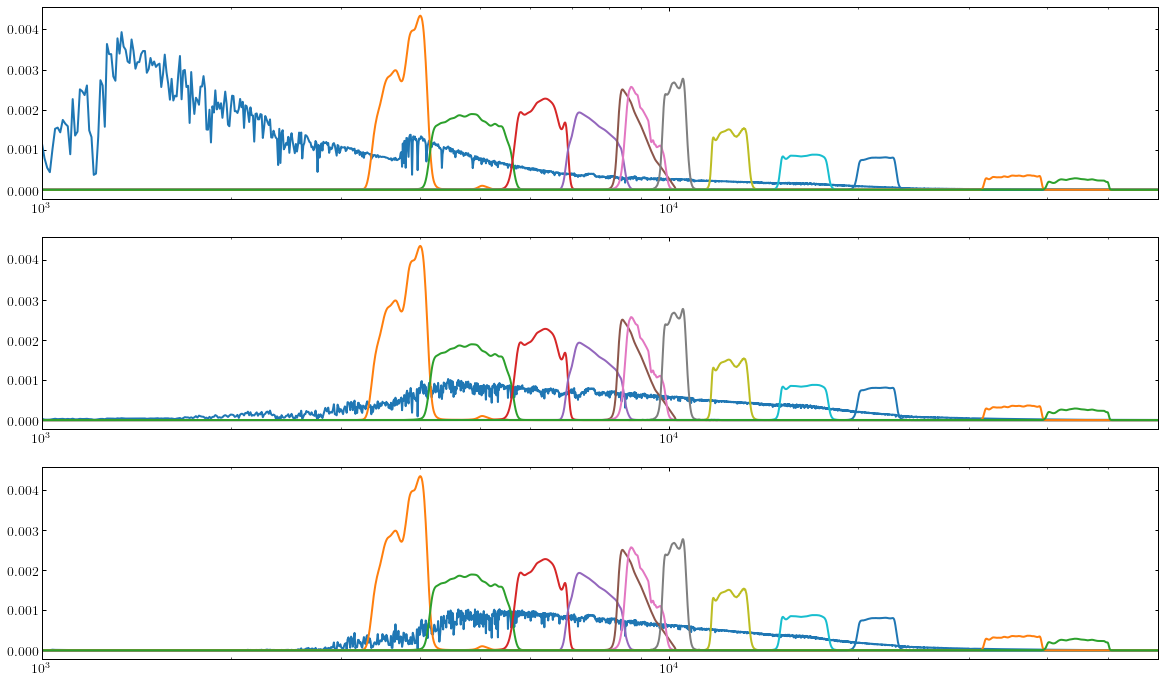

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
axes = [plt.subplot(311), plt.subplot(312), plt.subplot(313)]

for i in range(3):
    ax = axes[i]
    
    ax.plot(wavelengths, grid[:,10*(i+2)]/grid[:,10*(i+2)].sum())
    
    for j in range(12):
        normed_filt = resampled_filter_curves[j]
        normed_filt /= 4*resampled_filter_curves[j].sum()
        ax.plot(wavelengths, normed_filt)

    ax.set_xscale("log")
    ax.set_xlim(1000., 60000.)
    
plt.show()

Great, now we have our models and our filters on the same wavelength sampling, so all we need to do is to integrate over the product of the two to get our fluxes. Simple. Hmm... except that our observed galaxies aren't going to be in the rest-frame. Which means that our spectrum is going to shift to the right whilst our filter curves stay put, which is going to mess everything up. Damn.

## Dealing with redshifting

There are probably as many different ways of dealing with this problem as there are SED fitting codes. The obvious way is simply to redshift the spectral model each time you change redshift and then resample it back onto the 10 Angstron wavelength grid. However in my experience, the grids of stellar models are usually far more cumbersome than the filter curve files, so an alternative and faster method is to blueshift the filters each time you change redshift. We can write a quick function to do this like so.

In [21]:
def blueshift_filters(redshift):
    """ A function that resamples filters onto the same wavelength
    basis as the model spectrum at the specified redshift """
        
    resampled_filter_curves = []

    for filt in filter_curves:
        blueshifted_wavs = filt[:, 0]/(1 + redshift)
        
        resampled_filt = np.interp(wavelengths,
                                   blueshifted_wavs, filt[:, 1],
                                   left=0, right=0)
        
        resampled_filter_curves.append(resampled_filt)
        
    return resampled_filter_curves

Let's give this a quick test-drive at redshift 1.5.

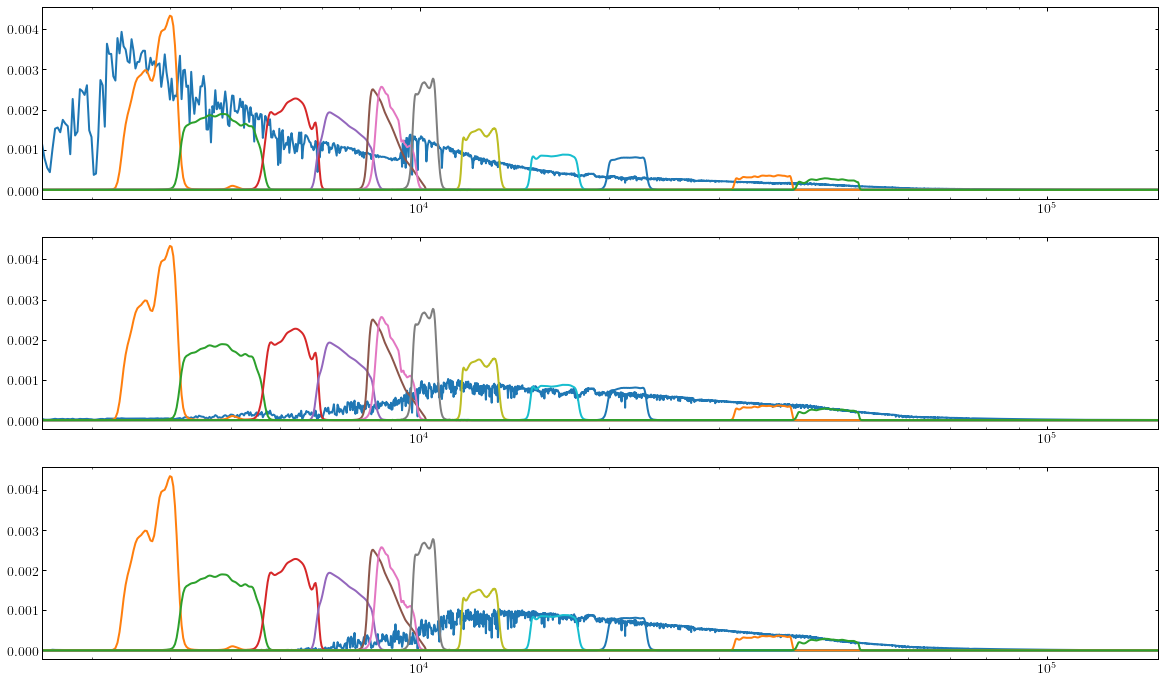

In [23]:
redshift = 1.5

resampled_filter_curves = blueshift_filters(redshift)

plt.figure(figsize=(20, 12))
axes = [plt.subplot(311), plt.subplot(312), plt.subplot(313)]

redshifted_wavs = wavelengths*(1+redshift)

for i in range(3):
    ax = axes[i]
    
    ax.plot(redshifted_wavs, grid[:,10*(i + 2)]/grid[:,10*(i + 2)].sum())
    
    for j in range(12):
        normed_filt = resampled_filter_curves[j]
        normed_filt /= 10*resampled_filter_curves[j].sum()
        ax.plot(redshifted_wavs, normed_filt)

    ax.set_xscale("log")
    ax.set_xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
    
plt.show()

Great, now we can generate filter curves that will sample our spectrum as if it were placed at any redshift we like. We still have to deal with converting our spectra from luminosities to fluxes at the observed redshift, but we'll cover that in the next example.